In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product 

In [3]:
df = pd.read_csv(r'C:\Users\macar\Documents\Maestria Data Science - Austral\ANALISIS DE SERIES TEMPORALES\Geochemical_Checklist_2.csv', sep=',') # leemos el archivo csv
pd.set_option('display.max_columns', None) # lo que realizamos aquí es que se muestren todas las columnas
print(df.head(5)) # mostramos las primeras 5 filas

  Project Despach N° RA-20XX-XXXX SampleID_Init SampleID_Fin  TotalSample_SE  \
0    BRAL            RA-2022-0013     BR1001081    BR1001082               2   
1    BRAL            RA-2022-0024     BR1001382    BR1001385               4   
2    BRAL            RA-2022-0025     BR1001533    BR1001545              13   
3    BRAL            RA-2022-0027     BR1000554    BR1000563              10   
4    BRAL            RA-2022-0035     BR1001546    BR1001553               8   

   Weight SE SampleType         Target Laboratory Prepared Method  \
0       5.87   RockChip    Aurora West        ALS         PREP-31   
1      11.89   RockChip  Varzea Alegre        ALS         PREP-31   
2      52.59       Soil  Varzea Alegre        ALS         PREP-31   
3      41.59  StreamSed   Farias Brito        ALS         PREP-41   
4      20.96       Soil  Varzea Alegre        ALS         PREP-31   

           Analytical Method DispatchDate Over Limit Analytes ReceivedDate  \
0           ME-MS61L+ME-MS

In [4]:
# Eliminamos las columnas que no necesitamos (FLSLoggedBy,FLSLoggedDate,FLSExported,MetadataID)
df = df.drop(['FLSLoggedBy', 'FLSLoggedDate', 'FLSExported', 'MetadataID'], axis=1)

In [5]:
#contamos los rows que corresponden al Analytical Method = TRSPEC-20
print(df[df['Analytical Method'] == 'TRSPEC-20'].shape[0])

#eliminamos esos dos ROWS ya que no corresponde a los datos que necesitamos.
df = df[df['Analytical Method'] != 'TRSPEC-20']


2


In [6]:
#transformamos las fechas a tipo datetime (dispatchDate, ReceivedDate,Resultdate) mes,dia,año
df['DispatchDate'] = pd.to_datetime(df['DispatchDate'])
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'])
df['ResultDate'] = pd.to_datetime(df['ResultDate'])
print(df.dtypes)

Project                            object
Despach N° RA-20XX-XXXX            object
SampleID_Init                      object
SampleID_Fin                       object
TotalSample_SE                      int64
Weight SE                         float64
SampleType                         object
Target                             object
Laboratory                         object
Prepared Method                    object
Analytical Method                  object
DispatchDate               datetime64[ns]
Over Limit                         object
Analytes                           object
ReceivedDate               datetime64[ns]
ResultDate                 datetime64[ns]
Workorder                          object
Location                           object
Responsible                        object
dtype: object


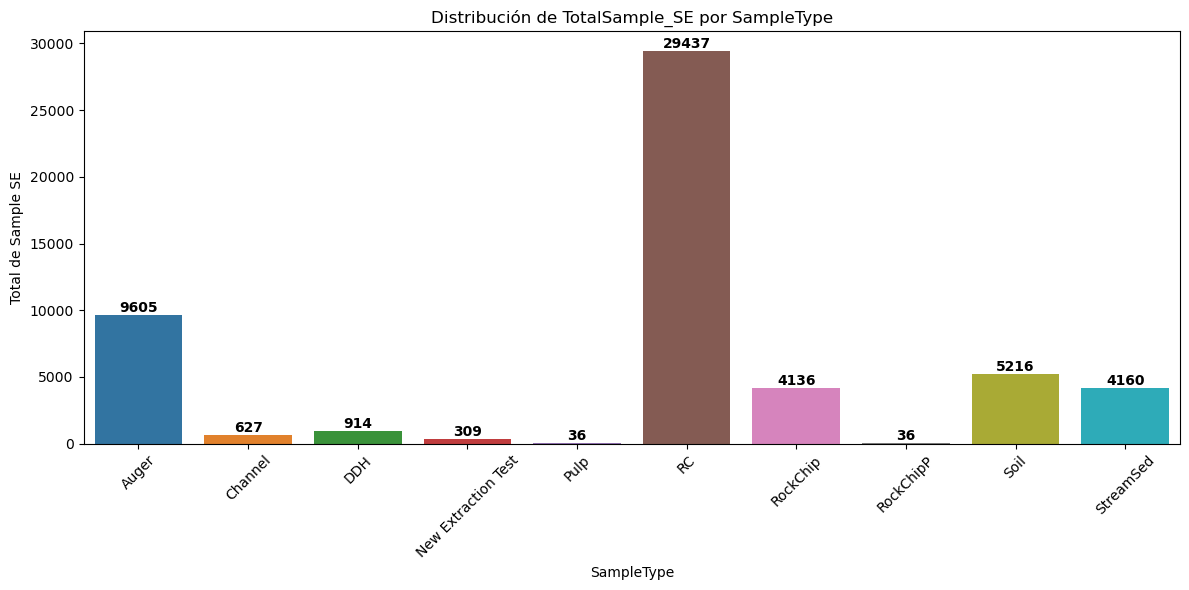

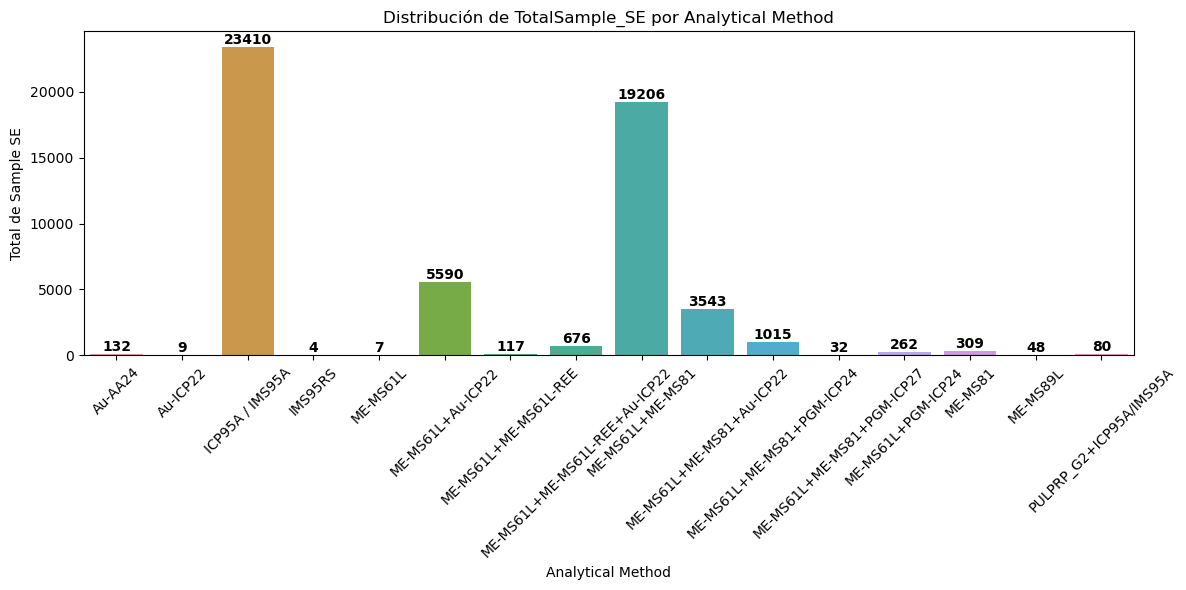

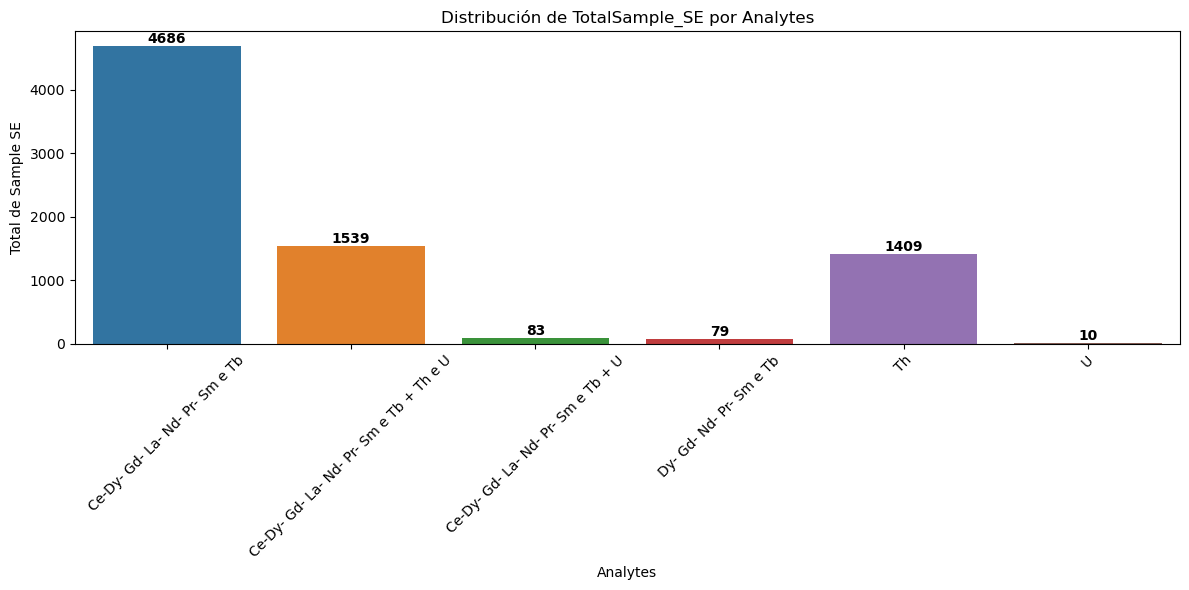

In [7]:
# Lista de columnas para las que queremos graficar la distribución de TotalSample_SE
columns = ['SampleType', 'Analytical Method', 'Analytes']

# Iterar sobre cada columna y generar el gráfico correspondiente
for col in columns:
    # Agrupar por la columna actual y sumar TotalSample_SE
    df_grouped = df.groupby(col)['TotalSample_SE'].sum().reset_index()
    
    # Crear el gráfico de barras
    plt.figure(figsize=(12, 6))
    sns.barplot(x=col, y='TotalSample_SE', data=df_grouped)
    
    # Agregar etiquetas de los valores en cada barra
    for index, row in df_grouped.iterrows():
        plt.text(index, row['TotalSample_SE'], f"{int(row['TotalSample_SE'])}", 
                 ha='center', va='bottom', fontweight='bold')
    
    # Personalizar etiquetas y título
    plt.xlabel(col)
    plt.ylabel('Total de Sample SE')
    plt.title(f'Distribución de TotalSample_SE por {col}')
    plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mayor legibilidad
    plt.tight_layout()  # Ajustar el layout para evitar recortes
    plt.show()


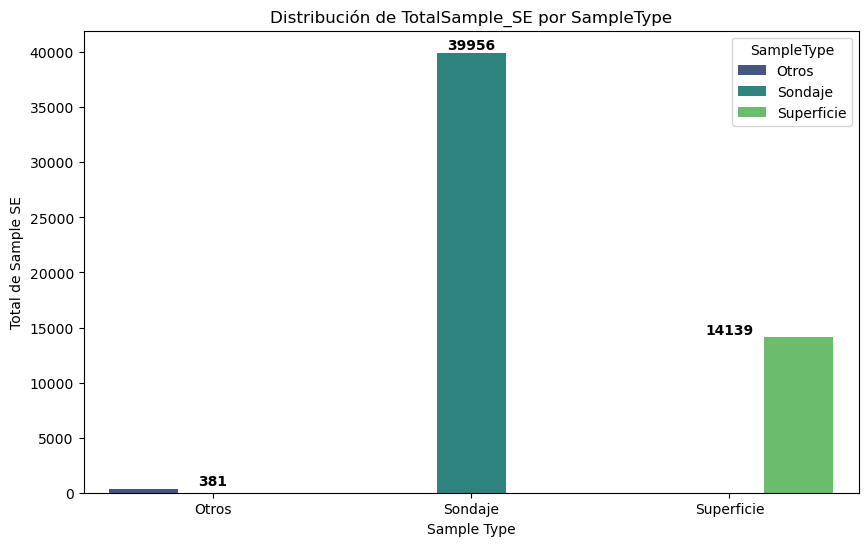

In [8]:
# Agrupamos Rockchip, Soil, Sream Sediment y Channel en una sola categoria llamada Superficie. Auger, DDH y RC en una categoria llamada Sondaje. Pulp, RockchipP, New Extraction test en una categoria llamada Otros
# Contamos TotalSample_SE y lo visualizamos segun las categorias.
# creamos una copia del dataframe llamada df1

# Copia del DataFrame
df1 = df.copy()

# Reemplazar los valores de SampleType según los grupos
df1['SampleType'] = df1['SampleType'].replace(['RockChip', 'Soil', 'StreamSed', 'Channel'], 'Superficie')
df1['SampleType'] = df1['SampleType'].replace(['Auger', 'DDH', 'RC'], 'Sondaje')
df1['SampleType'] = df1['SampleType'].replace(['Pulp', 'RockChipP', 'New Extraction Test'], 'Otros')

# Agrupar por SampleType y calcular la suma de TotalSample_SE
df_grouped = df1.groupby('SampleType')['TotalSample_SE'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='SampleType', y='TotalSample_SE', hue='SampleType', data=df_grouped, palette='viridis')

# Agregar etiquetas de los valores en cada barra
for index, row in df_grouped.iterrows():
    plt.text(index, row['TotalSample_SE'], f"{int(row['TotalSample_SE'])}", 
             ha='center', va='bottom', fontweight='bold')

plt.xlabel('Sample Type')
plt.ylabel('Total de Sample SE')
plt.title('Distribución de TotalSample_SE por SampleType')
plt.show()

  ReceivedDate ResultDate  Tiempo de Procesamiento MesRecibido
0   2022-05-24 2022-07-04                     41.0     2022-05
1   2022-06-30 2022-08-11                     42.0     2022-06
2   2022-06-30 2022-08-05                     36.0     2022-06
3   2022-06-30 2022-08-03                     34.0     2022-06
4   2022-07-19 2022-08-30                     42.0     2022-07


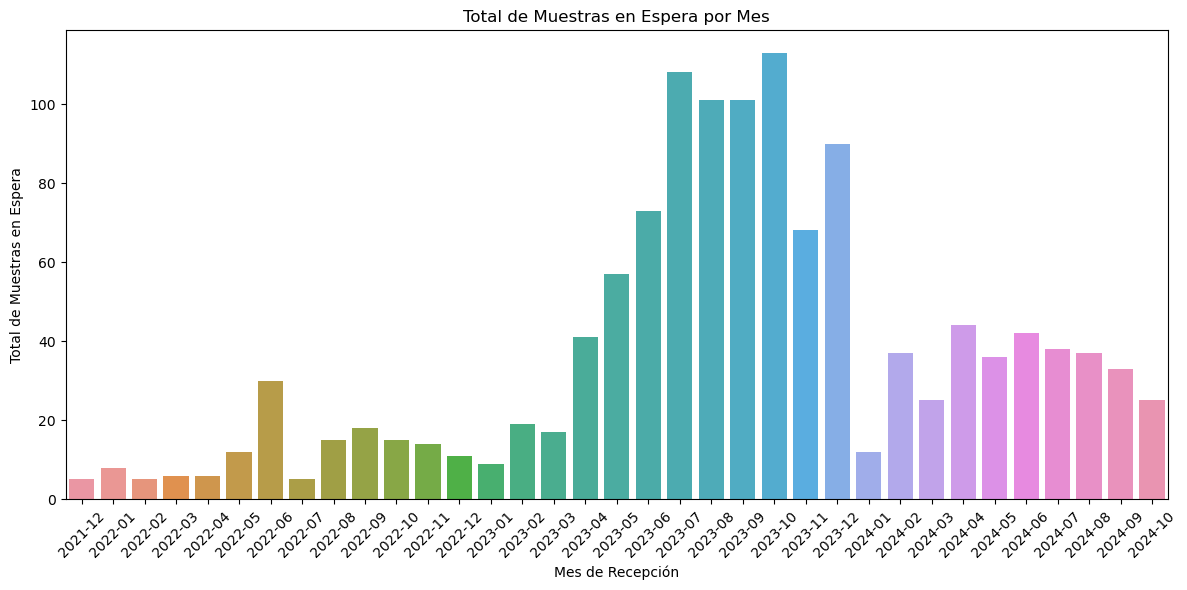

In [9]:
# Calcular el tiempo que demora el laboratorio en dar los resultados
df['Tiempo de Procesamiento'] = (df['ResultDate'] - df['ReceivedDate']).dt.days

# Crear una columna para el mes de recepción, basada en ReceivedDate
df['MesRecibido'] = df['ReceivedDate'].dt.to_period('M')  # Agrupación mensual

#visualimanos las nuevas columnas

print(df[['ReceivedDate', 'ResultDate', 'Tiempo de Procesamiento', 'MesRecibido']].head(5))

#graficar segun la cantidad de muestras en espera
# Calcular el total de muestras en espera por mes
df_grouped = df.groupby('MesRecibido')['TotalSample_SE'].count().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='MesRecibido', y='TotalSample_SE', data=df_grouped)

# Personalizar etiquetas y título
plt.xlabel('Mes de Recepción')
plt.ylabel('Total de Muestras en Espera')
plt.title('Total de Muestras en Espera por Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Creamos una variable df_2 que contenga solo TotalSample_SE y dispatchdate

df_dispatchdate = df[['TotalSample_SE', 'DispatchDate']]
print(df_dispatchdate.head(5))
print(df_dispatchdate.dtypes)

   TotalSample_SE DispatchDate
0               2   2022-05-16
1               4   2022-06-27
2              13   2022-06-27
3              10   2022-06-27
4               8   2022-07-13
TotalSample_SE             int64
DispatchDate      datetime64[ns]
dtype: object


              TotalSample_SE
DispatchDate                
2021-11-22               144
2021-11-30                81
2021-12-17                84
2022-01-13                26
2022-01-24                99


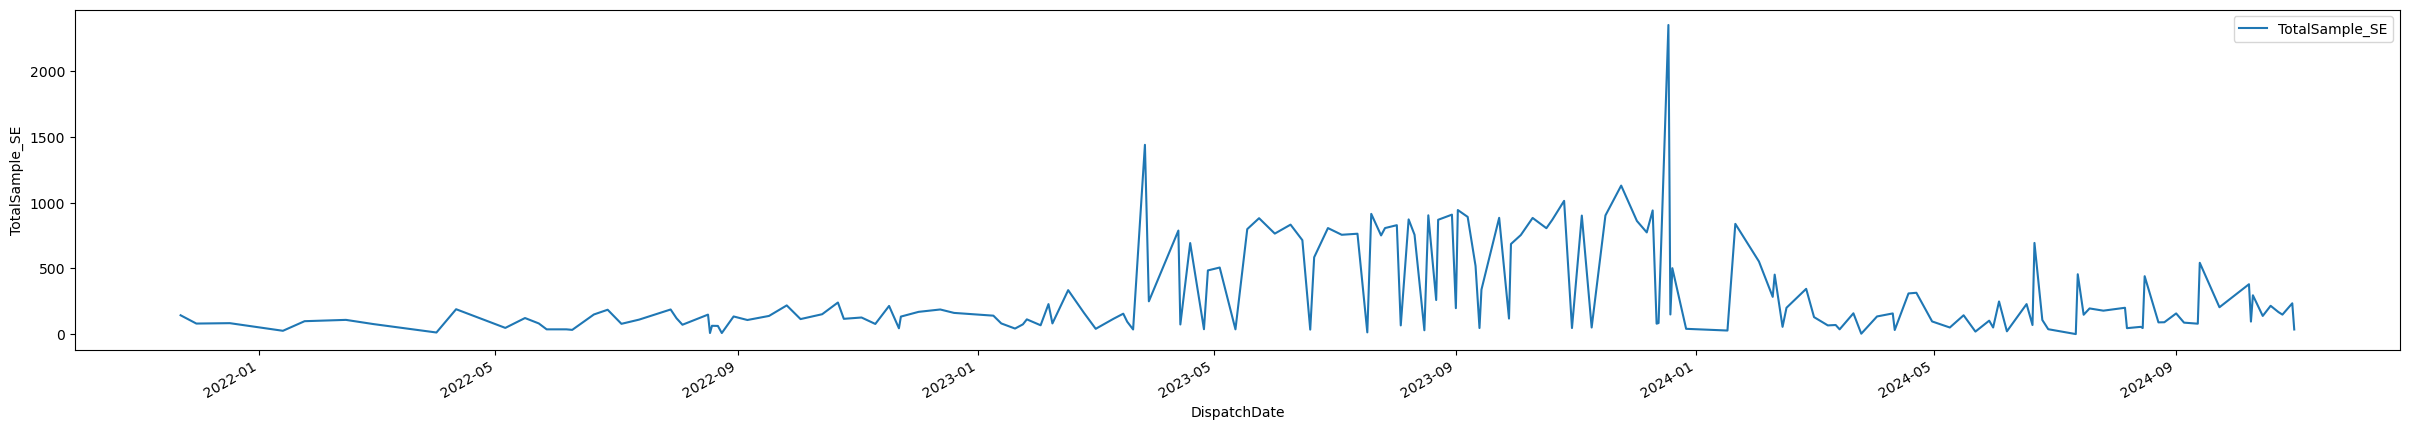

In [11]:
# Agrupamos la sumatoria de TotalSample_SE en las mismas fechas
df_dispatchdate_agrupado = df_dispatchdate.groupby('DispatchDate').sum()
print(df_dispatchdate_agrupado.head(5))

# Graficamos
df_dispatchdate_agrupado.plot(figsize=(30, 5))
plt.xlabel('DispatchDate')
plt.ylabel('TotalSample_SE')
plt.show()

In [12]:
df_receiveddate =df[['TotalSample_SE', 'ReceivedDate']]
print(df_receiveddate.head(5))
print(df_receiveddate.dtypes)

   TotalSample_SE ReceivedDate
0               2   2022-05-24
1               4   2022-06-30
2              13   2022-06-30
3              10   2022-06-30
4               8   2022-07-19
TotalSample_SE             int64
ReceivedDate      datetime64[ns]
dtype: object


              TotalSample_SE
ReceivedDate                
2021-12-03               144
2021-12-13                81
2022-01-05                84
2022-01-24                26
2022-01-31                99


<Axes: xlabel='ReceivedDate'>

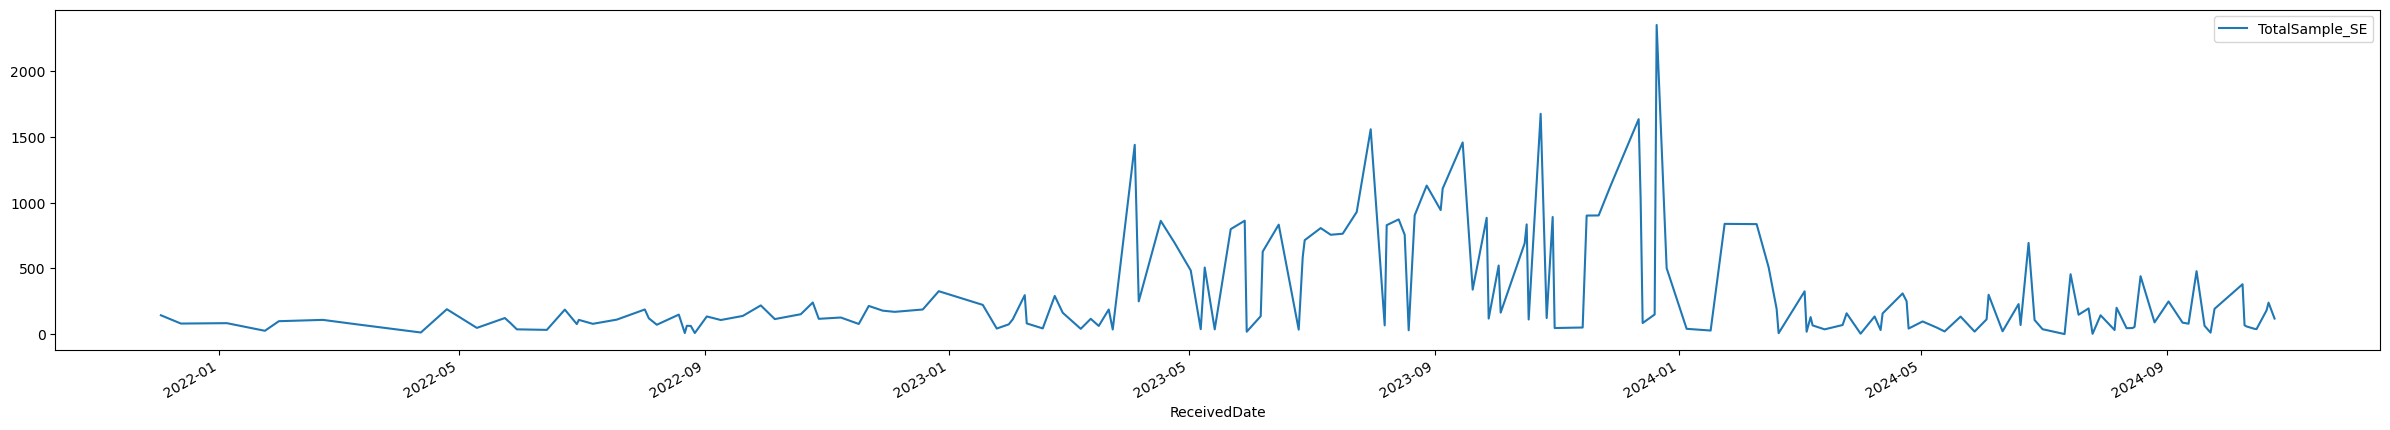

In [13]:
# Agrupamos la sumatoria de TotalSample_SE en las mismas fechas
df_receiveddate_agrupado = df_receiveddate.groupby('ReceivedDate').sum()
print(df_receiveddate_agrupado.head(5))

# Graficamos
df_receiveddate_agrupado.plot(figsize=(30, 5))

   TotalSample_SE ResultDate
0               2 2022-07-04
1               4 2022-08-11
2              13 2022-08-05
3              10 2022-08-03
4               8 2022-08-30
TotalSample_SE             int64
ResultDate        datetime64[ns]
dtype: object
            TotalSample_SE
ResultDate                
2022-01-20             144
2022-02-07              81
2022-02-19              84
2022-02-28               6
2022-03-01              11


<Axes: xlabel='ResultDate'>

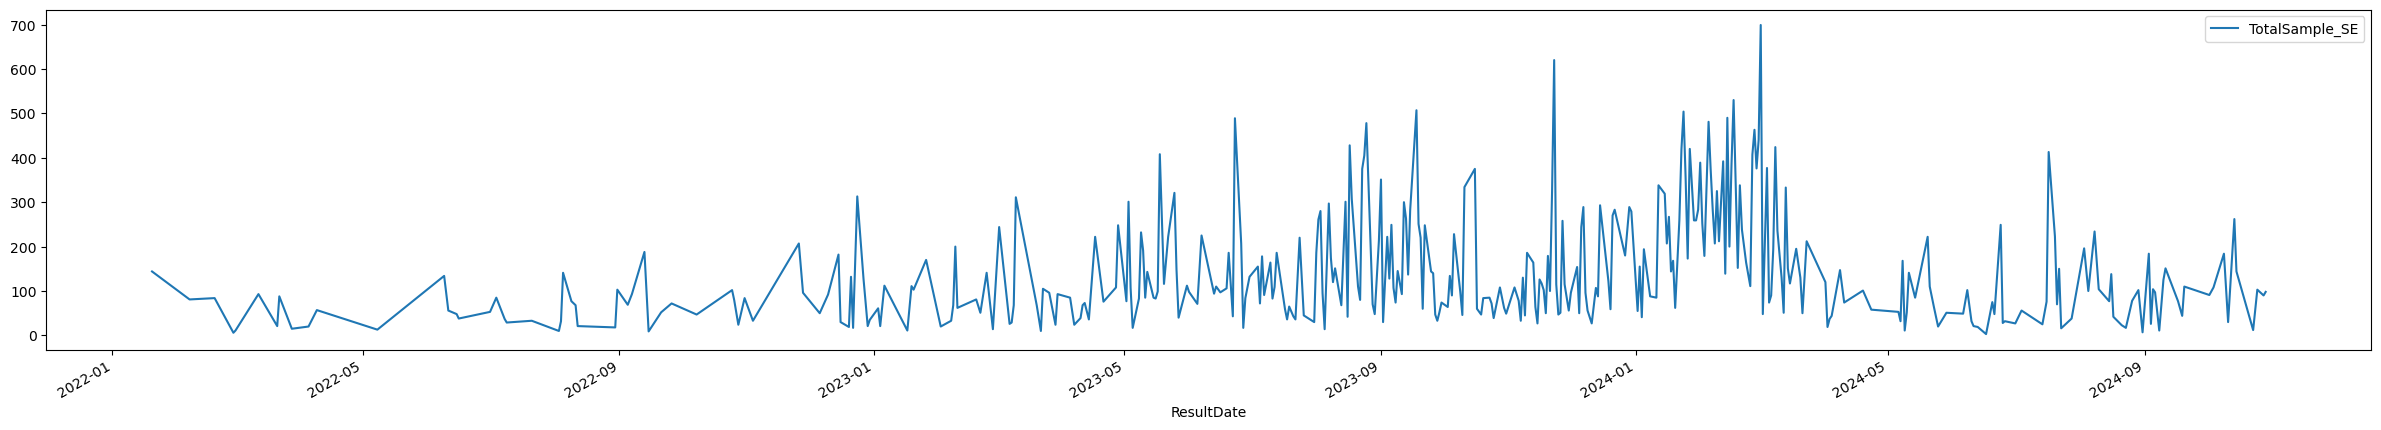

In [14]:
df_resultdate =df[['TotalSample_SE', 'ResultDate']]
print(df_resultdate.head(5))
print(df_resultdate.dtypes)

# Se agrupa la sumatoria de TotalSample_SE en las mismas fechas
df_resultdate_agrupado = df_resultdate.groupby('ResultDate').sum()
print(df_resultdate_agrupado.head(5))
#graficamos
df_resultdate_agrupado.plot(figsize=(30, 5))

Número total de observaciones: 172
Índice de tiempo: DatetimeIndex(['2021-12-03', '2021-12-13', '2022-01-05', '2022-01-24',
               '2022-01-31', '2022-02-22', '2022-03-10', '2022-04-12',
               '2022-04-25', '2022-05-10',
               ...
               '2024-09-23', '2024-09-25', '2024-10-09', '2024-10-10',
               '2024-10-11', '2024-10-15', '2024-10-16', '2024-10-21',
               '2024-10-22', '2024-10-25'],
              dtype='datetime64[ns]', name='ReceivedDate', length=172, freq=None)
Período sugerido: 12


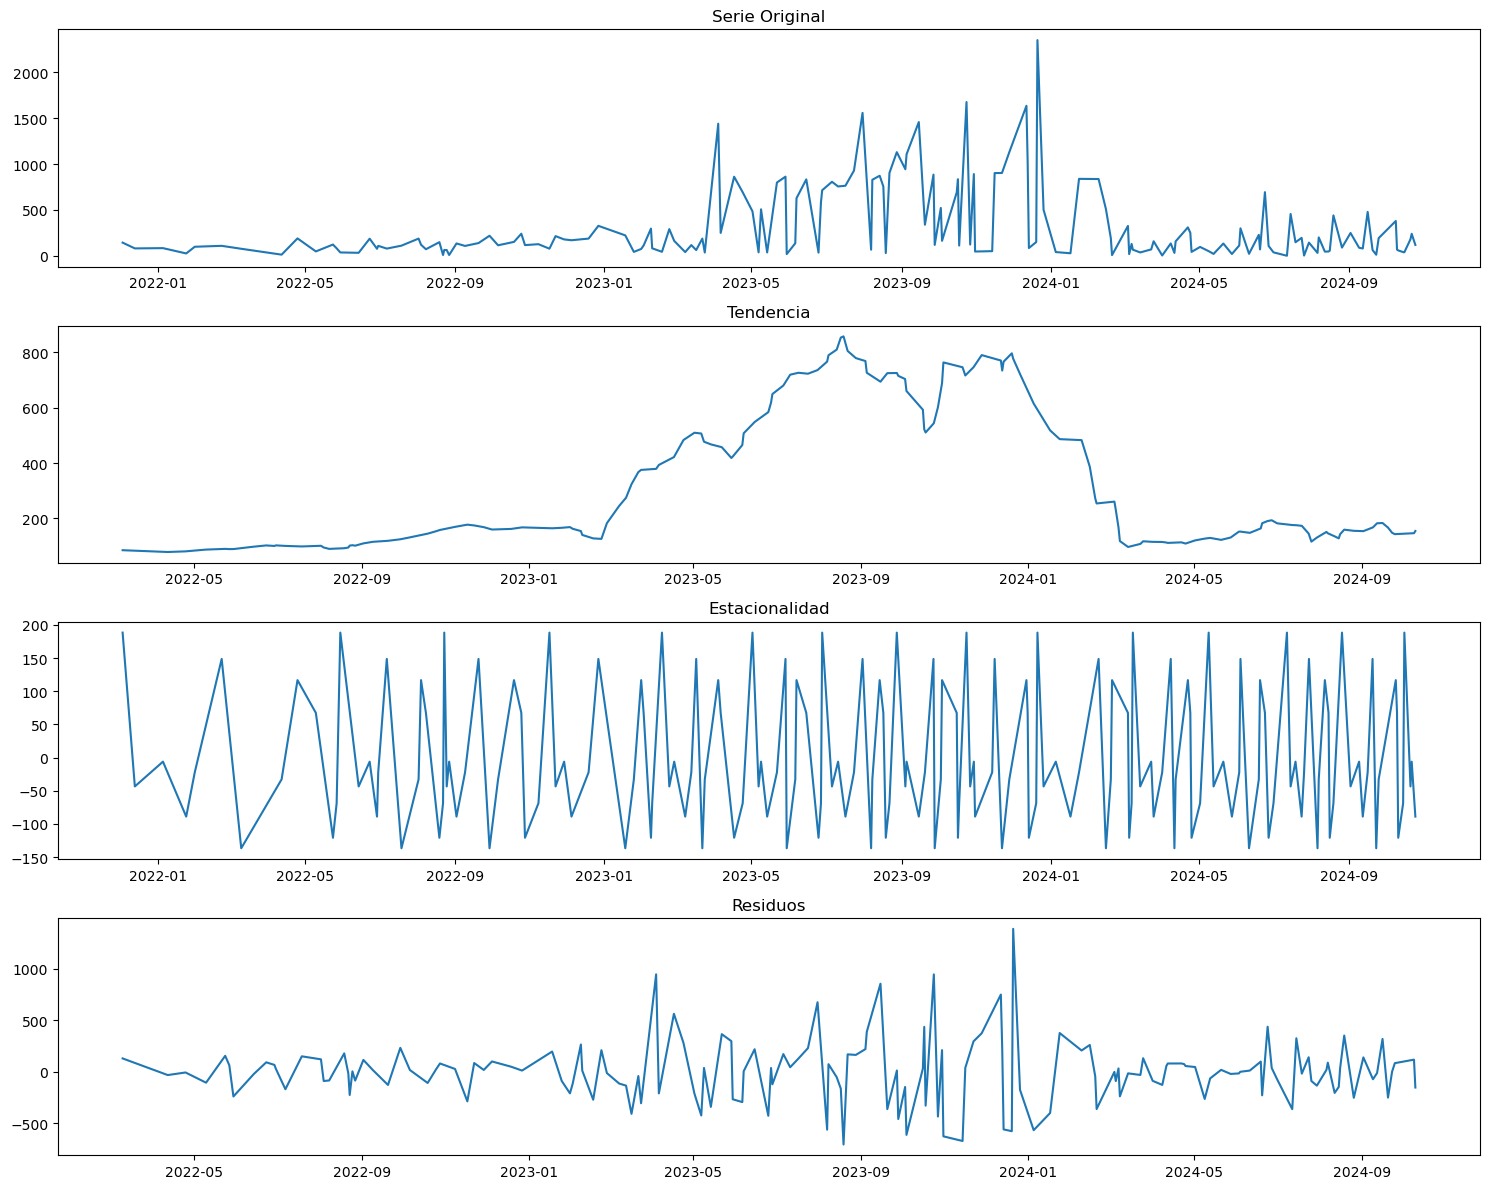

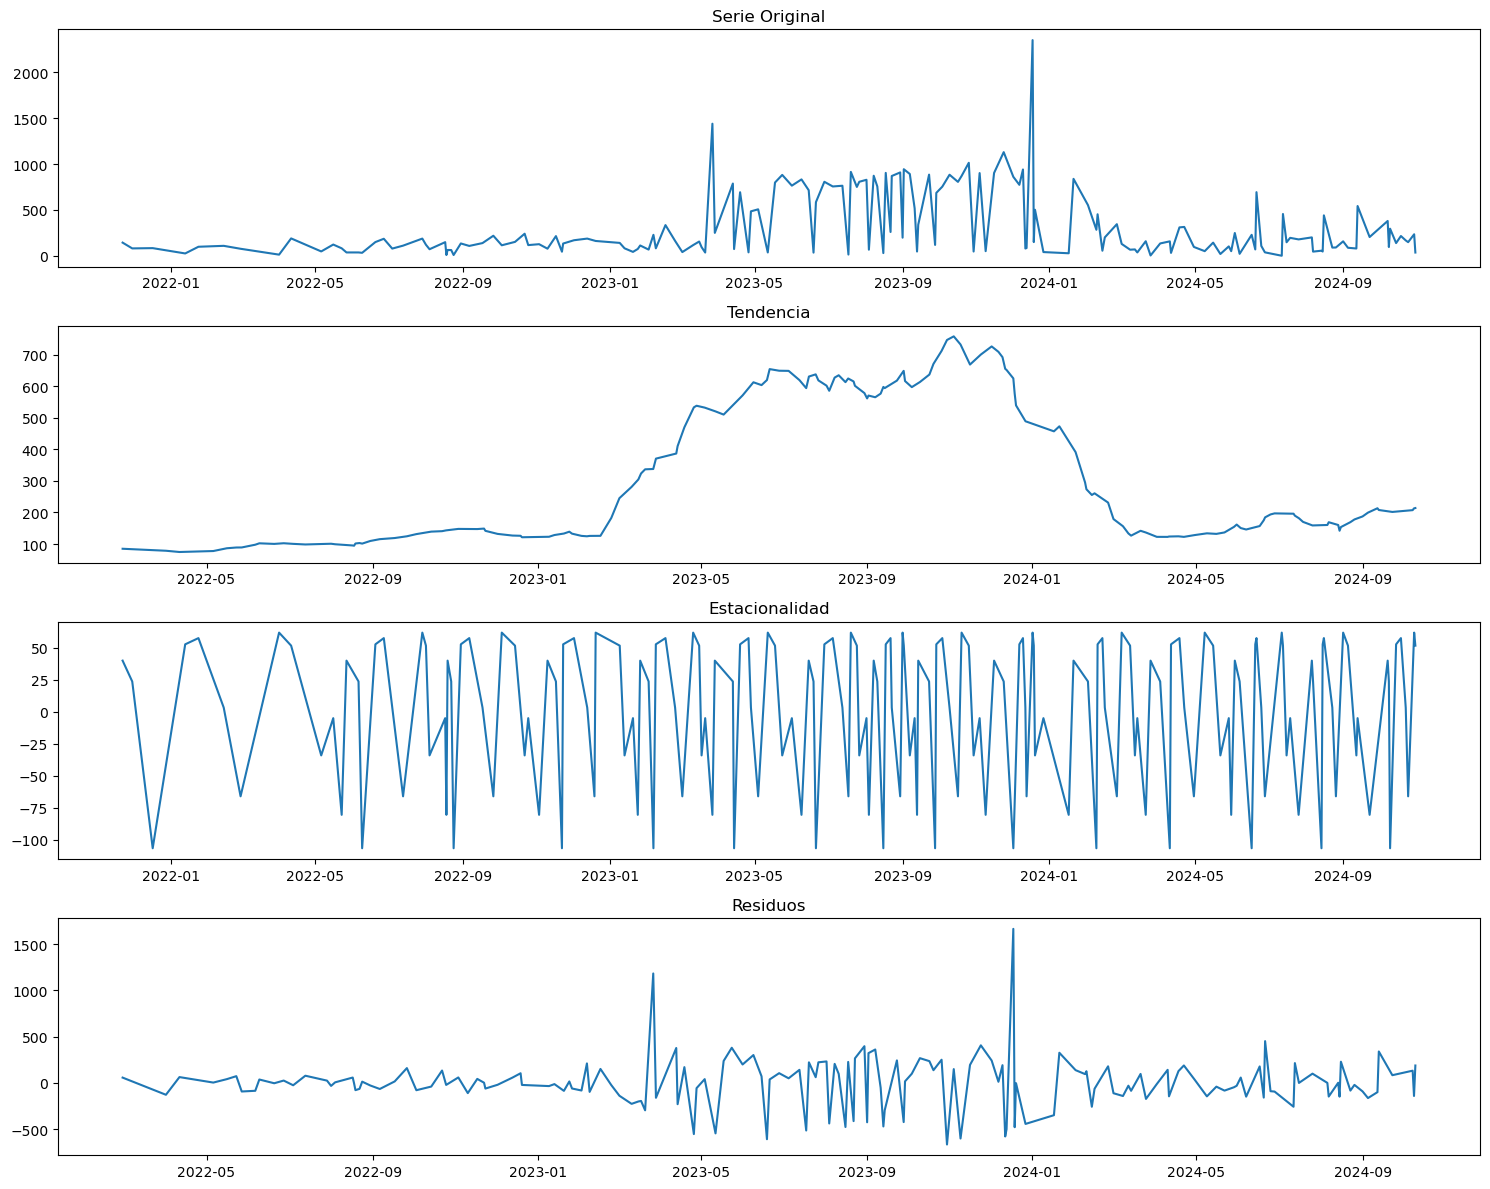

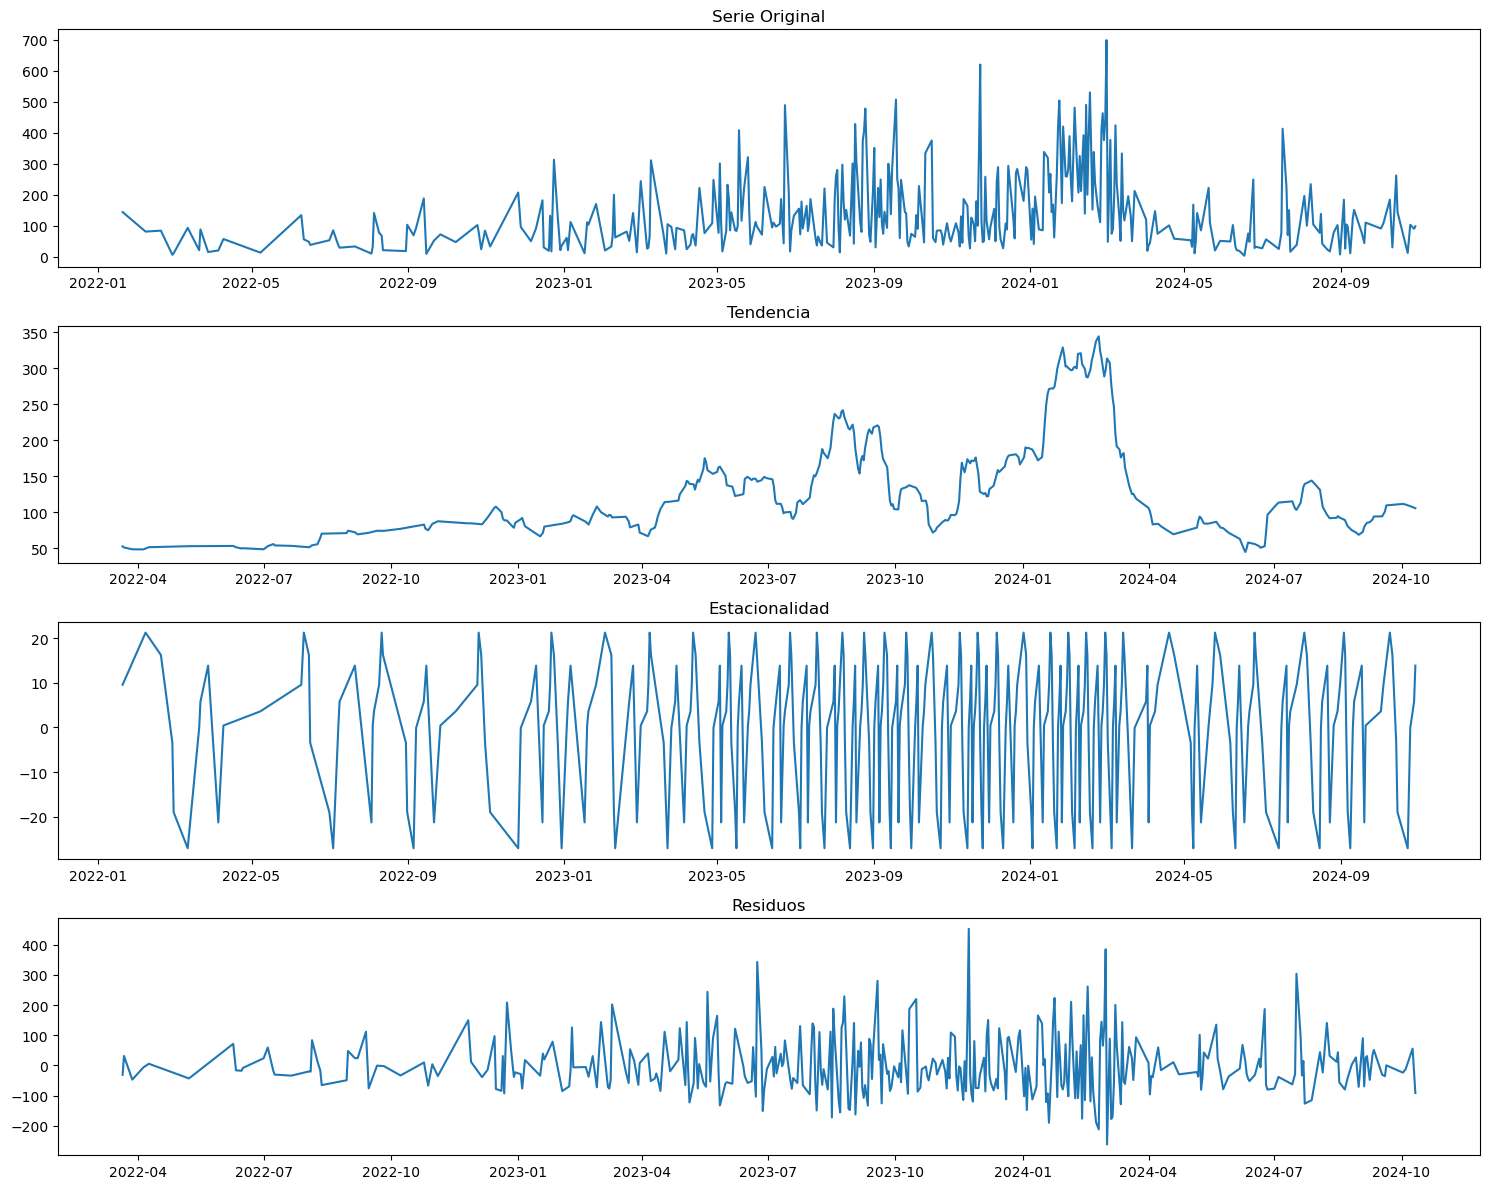

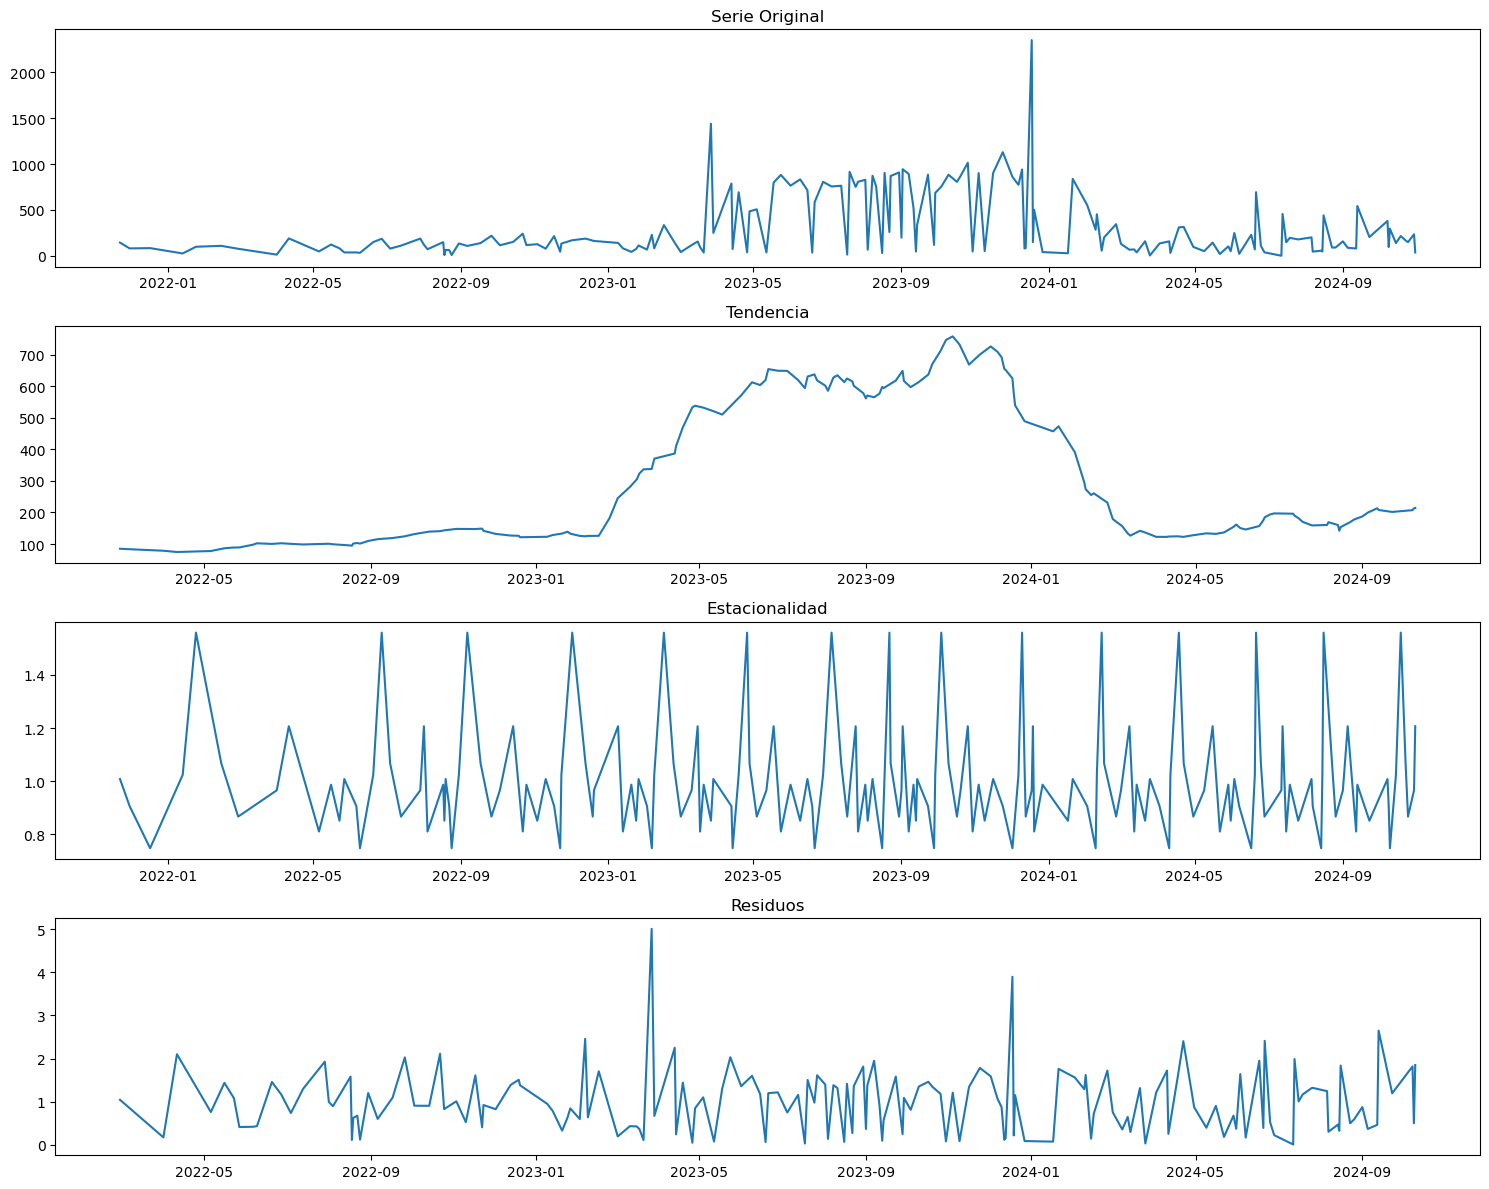

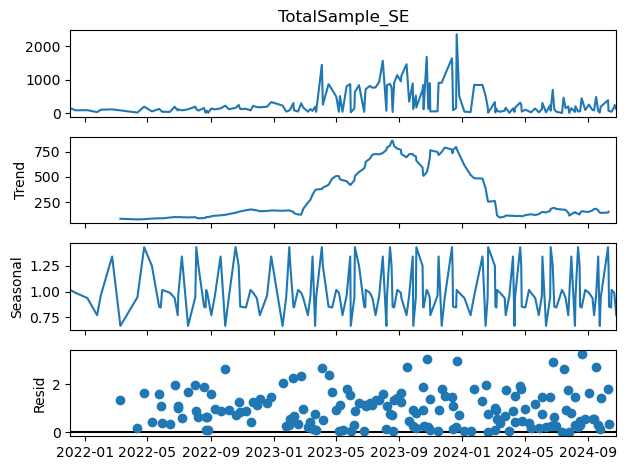

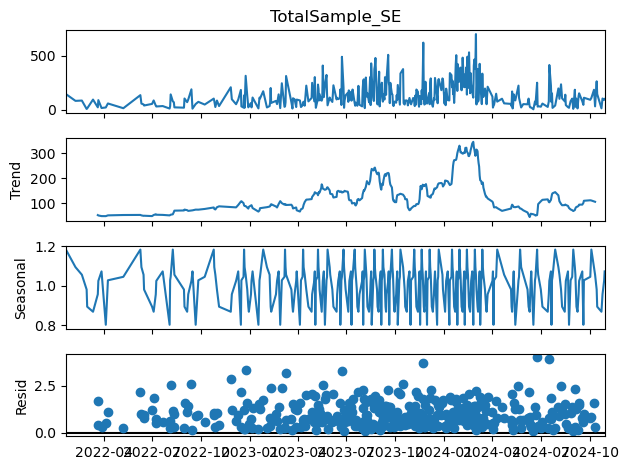

Prueba de estacionariedad para Dispatch Date:
Estadística ADF: -1.7843537854066605
Valor p: 0.38825680441184435
Número de lags utilizados: 6
Número de observaciones: 170
Valores críticos:
  1%: -3.469413468959902
  5%: -2.8786964197028295
  10%: -2.5759166089965397

Prueba de estacionariedad para Receive Date:
Estadística ADF: -1.6786330812097316
Valor p: 0.44215361182309715
Número de lags utilizados: 14
Número de observaciones: 157
Valores críticos:
  1%: -3.472703119504854
  5%: -2.880131672353732
  10%: -2.5766826861130268

Prueba de estacionariedad para Result Date:
Estadística ADF: -2.737093699460796
Valor p: 0.0678364313133047
Número de lags utilizados: 9
Número de observaciones: 371
Valores críticos:
  1%: -3.4480996560263386
  5%: -2.8693621113224137
  10%: -2.570937038891028


In [15]:
# Verificar la frecuencia de los datos
print("Número total de observaciones:", len(df_receiveddate_agrupado))
print("Índice de tiempo:", df_receiveddate_agrupado.index)

# Calcular un período apropiado basado en el número de observaciones
periodo_sugerido = min(12, len(df_receiveddate_agrupado) // 4)
print("Período sugerido:", periodo_sugerido)

# Realizar la descomposición con el período sugerido
result = seasonal_decompose(df_receiveddate_agrupado['TotalSample_SE'], 
                          model='additive', 
                          period=periodo_sugerido)

periodo = 12 

# Realizar la descomposición estacional aditiva de la serie Received date
result = seasonal_decompose(df_receiveddate_agrupado['TotalSample_SE'], 
                          model='additive', 
                          period=periodo)

# Graficar la descomposición
plt.figure(figsize=(15, 12))

# Serie original
plt.subplot(411)
plt.plot(result.observed)
plt.title('Serie Original', fontsize=12)
plt.xlabel('')

# Tendencia
plt.subplot(412)
plt.plot(result.trend)
plt.title('Tendencia', fontsize=12)
plt.xlabel('')

# Estacionalidad
plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Estacionalidad', fontsize=12)
plt.xlabel('')

# Residuos
plt.subplot(414)
plt.plot(result.resid)
plt.title('Residuos', fontsize=12)

plt.tight_layout()
plt.show()

periodo = 12 

# Realizar la descomposición estacional aditiva de la serie Dispatch date
result = seasonal_decompose(df_dispatchdate_agrupado['TotalSample_SE'], 
                          model='additive', 
                          period=periodo)

# Graficar la descomposición
plt.figure(figsize=(15, 12))

# Serie original
plt.subplot(411)
plt.plot(result.observed)
plt.title('Serie Original', fontsize=12)
plt.xlabel('')

# Tendencia
plt.subplot(412)
plt.plot(result.trend)
plt.title('Tendencia', fontsize=12)
plt.xlabel('')

# Estacionalidad
plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Estacionalidad', fontsize=12)
plt.xlabel('')

# Residuos
plt.subplot(414)
plt.plot(result.resid)
plt.title('Residuos', fontsize=12)

plt.tight_layout()
plt.show()

periodo = 12 

# Realizar la descomposición estacional aditiva de la serie Result date
result = seasonal_decompose(df_resultdate_agrupado['TotalSample_SE'], 
                          model='additive', 
                          period=periodo)

# Graficar la descomposición
plt.figure(figsize=(15, 12))

# Serie original
plt.subplot(411)
plt.plot(result.observed)
plt.title('Serie Original', fontsize=12)
plt.xlabel('')

# Tendencia
plt.subplot(412)
plt.plot(result.trend)
plt.title('Tendencia', fontsize=12)
plt.xlabel('')

# Estacionalidad
plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Estacionalidad', fontsize=12)
plt.xlabel('')

# Residuos
plt.subplot(414)
plt.plot(result.resid)
plt.title('Residuos', fontsize=12)

plt.tight_layout()
plt.show()

# Realizar la descomposición estacional multiplicativa
result = seasonal_decompose(df_dispatchdate_agrupado['TotalSample_SE'], model='multiplicative' , period=12)

# Graficar los resultados

# Graficar la descomposición
plt.figure(figsize=(15, 12))

# Serie original
plt.subplot(411)
plt.plot(result.observed)
plt.title('Serie Original', fontsize=12)
plt.xlabel('')

# Tendencia
plt.subplot(412)
plt.plot(result.trend)
plt.title('Tendencia', fontsize=12)
plt.xlabel('')

# Estacionalidad
plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Estacionalidad', fontsize=12)
plt.xlabel('')

# Residuos
plt.subplot(414)
plt.plot(result.resid)
plt.title('Residuos', fontsize=12)

plt.tight_layout()
plt.show()

# Realizar la descomposición estacional multiplicativa
result = seasonal_decompose(df_receiveddate_agrupado['TotalSample_SE'], model='multiplicative' , period=12)

# Graficar los resultados

result.plot()
plt.show()

# Realizar la descomposición estacional multiplicativa
result = seasonal_decompose(df_resultdate_agrupado['TotalSample_SE'], model='multiplicative' , period=12)

# Graficar los resultados

result.plot()
plt.show()

# Análisis para diferenciarlas
# Puedes usar la prueba de Dickey-Fuller para verificar la estacionariedad
from statsmodels.tsa.stattools import adfuller

def test_estacionariedad(serie):
    resultado = adfuller(serie)
    print(f'Estadística ADF: {resultado[0]}')
    print(f'Valor p: {resultado[1]}')
    print(f'Número de lags utilizados: {resultado[2]}')
    print(f'Número de observaciones: {resultado[3]}')
    print('Valores críticos:')
    for key, value in resultado[4].items():
        print(f'  {key}: {value}')

# Prueba de estacionariedad en cada serie
print("Prueba de estacionariedad para Dispatch Date:")
test_estacionariedad(df_dispatchdate_agrupado['TotalSample_SE'])

print("\nPrueba de estacionariedad para Receive Date:")
test_estacionariedad(df_receiveddate_agrupado['TotalSample_SE'])

print("\nPrueba de estacionariedad para Result Date:")
test_estacionariedad(df_resultdate_agrupado['TotalSample_SE'])

In [16]:
# Definir las series temporales
series = {
    'Dispatch': df_dispatchdate_agrupado['TotalSample_SE'],
    'Result': df_resultdate_agrupado['TotalSample_SE'],
    'Received': df_receiveddate_agrupado['TotalSample_SE']
}

Modelo XGBoost

MAE: 151.91, RMSE: 202.03, MAPE: 529.04%


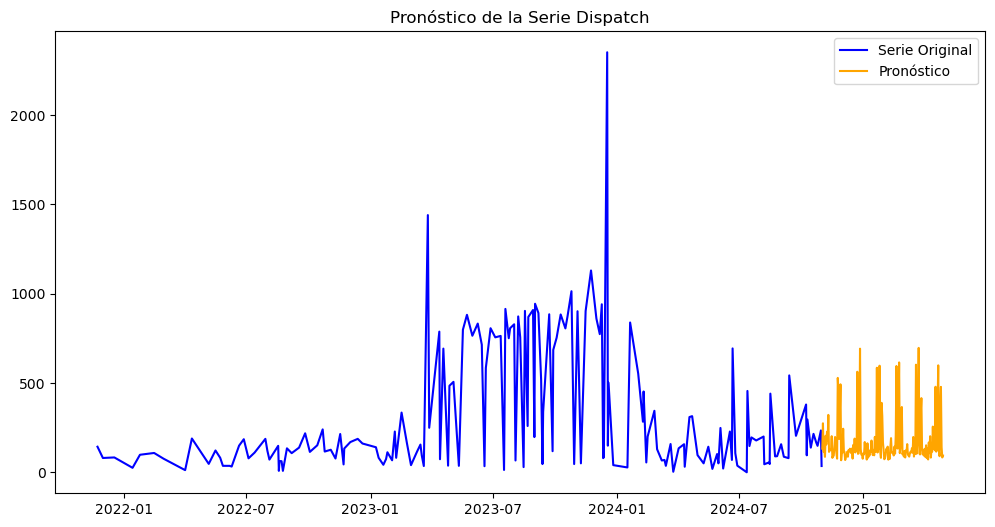

Pronóstico para la serie Dispatch:
2024-11-01    133.231445
2024-11-02    275.049805
2024-11-03    115.507538
2024-11-04    130.719360
2024-11-05     87.330467
                 ...    
2025-04-25    382.365173
2025-04-26    478.810516
2025-04-27    140.764374
2025-04-28     83.742737
2025-04-29     94.642761
Freq: D, Length: 180, dtype: float32
Métricas para Dispatch: MAE: 151.91, RMSE: 202.03, MAPE: 529.04%

--------------------------------------------------

MAE: 73.21, RMSE: 90.30, MAPE: 253.06%


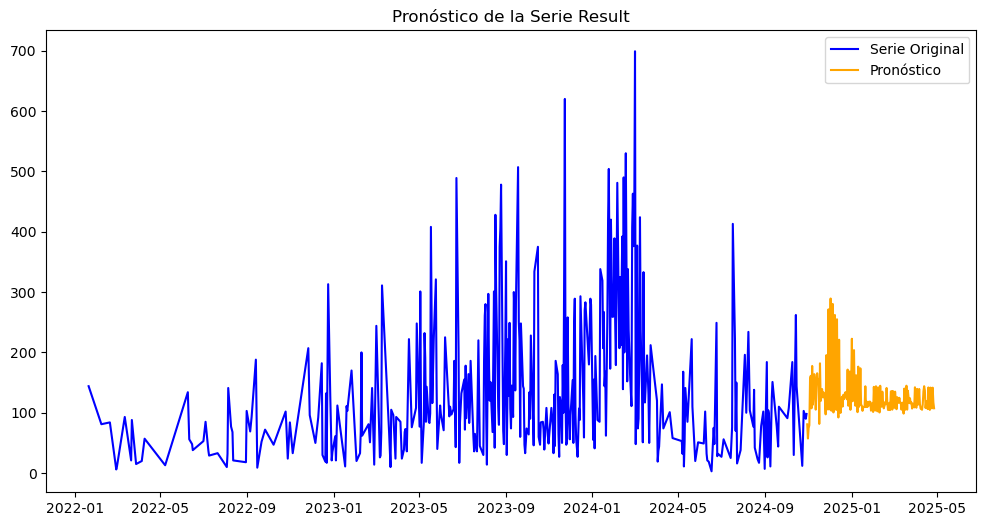

Pronóstico para la serie Result:
2024-10-30     80.809563
2024-10-31     57.297829
2024-11-01     74.564598
2024-11-02     79.351273
2024-11-03    156.002243
                 ...    
2025-04-23    114.720604
2025-04-24    107.302727
2025-04-25    141.530243
2025-04-26    117.177765
2025-04-27    107.400421
Freq: D, Length: 180, dtype: float32
Métricas para Result: MAE: 73.21, RMSE: 90.30, MAPE: 253.06%

--------------------------------------------------

MAE: 152.29, RMSE: 185.47, MAPE: 1069.97%


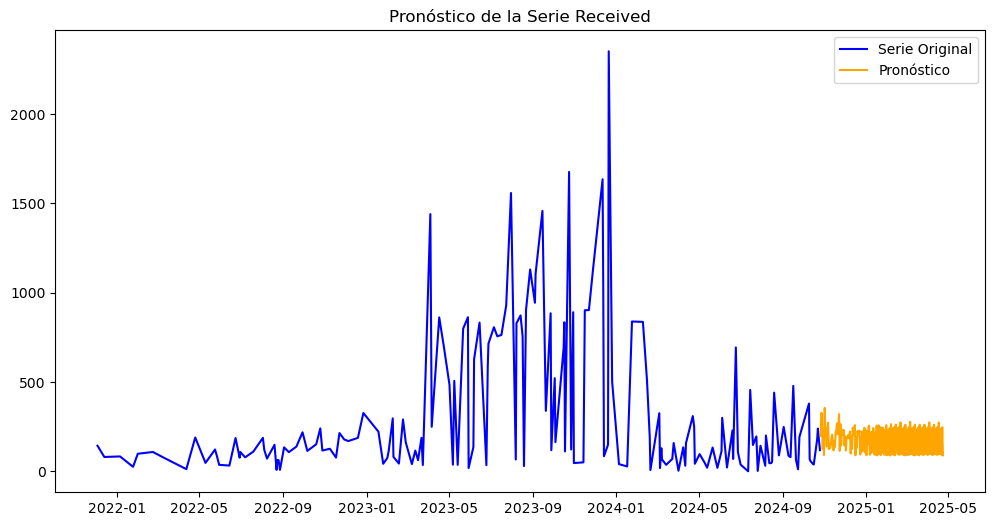

Pronóstico para la serie Received:
2024-10-26    198.652740
2024-10-27    328.208862
2024-10-28    320.635498
2024-10-29    124.809494
2024-10-30    197.618912
                 ...    
2025-04-19    239.722763
2025-04-20    164.553940
2025-04-21     93.107620
2025-04-22    247.583054
2025-04-23     90.383865
Freq: D, Length: 180, dtype: float32
Métricas para Received: MAE: 152.29, RMSE: 185.47, MAPE: 1069.97%

--------------------------------------------------


Resumen de métricas:
Dispatch: MAE: 151.91, RMSE: 202.03, MAPE: 529.04%
Result: MAE: 73.21, RMSE: 90.30, MAPE: 253.06%
Received: MAE: 152.29, RMSE: 185.47, MAPE: 1069.97%


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Definir las series temporales
series = {
    'Dispatch': df_dispatchdate_agrupado['TotalSample_SE'],
    'Result': df_resultdate_agrupado['TotalSample_SE'],
    'Received': df_receiveddate_agrupado['TotalSample_SE']
}

# Parámetros del modelo
past_steps = 30  # Número de días previos usados como features
future_steps = 180  # Predicción de 6 meses

# Función para calcular métricas de error
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # MAPE en porcentaje
    return mae, rmse, mape

# Función para preparar datos y entrenar el modelo XGBoost
def forecast_xgboost(series, past_steps, future_steps):
    data = pd.DataFrame(series)
    
    # Crear retardos
    for i in range(1, past_steps + 1):
        data[f'lag_{i}'] = data['TotalSample_SE'].shift(i)
    
    # Agregar tendencia y estacionalidad como features
    data['trend'] = np.arange(len(data))
    data['month'] = data.index.month
    data['dayofyear'] = data.index.dayofyear
    
    data.dropna(inplace=True)
    
    # Definir features (X) y target (y)
    X = data.drop(columns=['TotalSample_SE'])
    y = data['TotalSample_SE']
    
    # Verificar si hay suficientes datos para la división
    if len(X) == 0 or len(y) == 0:
        raise ValueError("No hay suficientes datos para entrenar el modelo. Reduce past_steps o future_steps.")
    
    # División en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Entrenar modelo XGBoost
    model = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluación del modelo
    y_pred = model.predict(X_test)
    mae, rmse, mape = calculate_metrics(y_test, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    
    # Predicción iterativa para los próximos 6 meses
    last_values = X.iloc[-1].values.reshape(1, -1)
    future_predictions = []
    
    for _ in range(future_steps):
        next_pred = model.predict(last_values)[0]
        future_predictions.append(next_pred)
        last_values = np.roll(last_values, -1)
        last_values[0, -1] = next_pred
    
    # Crear índice de fechas futuras
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)
    
    return future_dates, future_predictions, mae, rmse, mape

# Realizar el pronóstico para cada serie
graphs = {}
metrics_results = {}

for name, serie_temporal in series.items():
    future_dates, forecast, mae, rmse, mape = forecast_xgboost(serie_temporal, past_steps, future_steps)
    
    # Guardar métricas
    metrics_results[name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
    
    # Graficar el pronóstico
    plt.figure(figsize=(12, 6))
    plt.plot(serie_temporal, label='Serie Original', color='blue')
    plt.plot(future_dates, forecast, label='Pronóstico', color='orange')
    plt.title(f'Pronóstico de la Serie {name}')
    plt.legend()
    plt.show()
    
    # Guardar los datos para inspección
    graphs[name] = (future_dates, forecast)
    
    # Mostrar el pronóstico y métricas
    print(f"Pronóstico para la serie {name}:")
    print(pd.Series(forecast, index=future_dates))
    print(f"Métricas para {name}: MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    print("\n" + "-"*50 + "\n")

# Mostrar métricas finales
print("\nResumen de métricas:")
for name, metrics in metrics_results.items():
    print(f"{name}: MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, MAPE: {metrics['MAPE']:.2f}%")
